# Deformable Classifier Testing

In [1]:
import numpy as np
import tensorflow as tf
import cv2
import math
from mpl_toolkits.axes_grid1 import AxesGrid
from math import ceil
import keras
from keras.datasets import mnist 
from keras.models import Model ,Sequential
from keras.layers import Dense, Input
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten 
from keras import backend as k 
from scipy import ndimage
import matplotlib.pyplot as plt
import os
import sys
from keras.applications.imagenet_utils import preprocess_input
from keras.models import load_model

sys.path.append('..')
from utils import RotNetDataGenerator, angle_error, binarize_images, get_deformations

Using TensorFlow backend.


In [2]:
test_data_path = 'test.p'

data = np.load(test_data_path, allow_pickle=True)

temp = np.zeros((data['features'].shape[0], data['features'].shape[1], data['features'].shape[2]))
for idx in range(data['features'].shape[0]):
    temp[idx] = cv2.cvtColor(data['features'][idx], cv2.COLOR_BGR2GRAY)
x_test = temp

y_test = data['labels']


batch_size = 128

### Here we test the entire classifier on specified inputs and models

In [19]:
def evaluate_deformable_classifier(input_dim, classifier_input_dim, num_classes, loc_net_model_location,
                                   classifier_model_location, max_angle):
    
    global x_test, y_test
    
    num_images = x_test.shape[0]
    loc_model = load_model(loc_net_model_location, custom_objects={'angle_error': angle_error})

    thetas, x_test_rotated = get_deformations(
        loc_model, 
        x_test[:num_images],
        num_images=num_images,
        preprocess_func=binarize_images,
        display=False,
        max_angle=max_angle
    )


    p = 3
    stn_output = np.zeros((num_images,input_dim-2*p,input_dim-2*p))
    idx = 0
    flag=0
    i = 0
    for angle in thetas:
        img = x_test_rotated[idx]

        rows,cols = img.shape

        M = cv2.getRotationMatrix2D((cols/2,rows/2),-angle,1)
        dst = cv2.warpAffine(img,M,(cols,rows))[p:-p,p:-p]

        stn_output[i] = dst
        i += 1

        idx += 1


    x_test_classifier, y_test_classifier = stn_output, y_test[0:num_images]

#     temp = np.zeros((x_train_classifier.shape[0], classifier_input_dim, classifier_input_dim))
#     for idx in range(x_train_classifier.shape[0]):
#         temp[idx] = cv2.resize(x_train_classifier[idx], (classifier_input_dim, classifier_input_dim))
#     x_train_classifier = temp.copy()

    temp = np.zeros((x_test_classifier.shape[0], classifier_input_dim, classifier_input_dim))
    for idx in range(x_test_classifier.shape[0]):
        temp[idx] = cv2.resize(x_test_classifier[idx], (classifier_input_dim, classifier_input_dim))
    x_test_classifier = temp


    img_rows, img_cols = classifier_input_dim, classifier_input_dim

#     x_train_classifier = x_train_classifier.reshape(x_train.shape[0], classifier_input_dim, classifier_input_dim, 1)
    x_test_classifier = x_test_classifier.reshape(x_test_classifier.shape[0], img_rows, img_cols, 1) 

    inpx = (img_rows, img_cols, 1) 

#     y_train_classifier = keras.utils.to_categorical(y_train_classifier, num_classes)    #One Hot Encode
    y_test_classifier = keras.utils.to_categorical(y_test_classifier, num_classes)      #One Hot Encode

    inpx = Input(shape=inpx) 
    layer1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inpx) 
    layer2 = Conv2D(64, (3, 3), activation='relu')(layer1) 
    layer3 = MaxPooling2D(pool_size=(3, 3))(layer2) 
    layer4 = Dropout(0.5)(layer3) 
    layer5 = Flatten()(layer4) 
    layer6 = Dense(250, activation='sigmoid')(layer5) 
    layer7 = Dense(num_classes, activation='softmax')(layer6) 
    model = Model([inpx], layer7) 
    model.compile(optimizer=keras.optimizers.Adadelta(), loss=keras.losses.categorical_crossentropy, metrics=['accuracy']) 

    model.load_weights(classifier_model_location)


    score = model.evaluate(x_test_classifier, y_test_classifier, verbose=0)
    print('Loss:', score[0])
    print('Accuracy:', score[1]) 

# Test Results:

## On Traffic Sign Dataset

#### On maximum rotation 45 degrees

In [4]:
input_dim = 32
classifier_input_dim = 32
num_classes = 43

loc_net_model_name = 'loc_net_45.hdf5'
loc_net_model_location = os.path.join('..', 'train', 'models', loc_net_model_name)

classifier_model_name = 'classifier_model.h5'
classifier_model_location = os.path.join('.', classifier_model_name)

evaluate_deformable_classifier(input_dim, classifier_input_dim, num_classes, loc_net_model_location, 
                               classifier_model_location, 45)

Loss: 0.346851474792
Accuracy: 0.918210609678


#### On maximum rotation 90 degrees

In [5]:
input_dim = 32
classifier_input_dim = 32
num_classes = 43

loc_net_model_name = 'loc_net_90.hdf5'
loc_net_model_location = os.path.join('..', 'train', 'models', loc_net_model_name)

classifier_model_name = 'classifier_model.h5'
classifier_model_location = os.path.join('.', classifier_model_name)

evaluate_deformable_classifier(input_dim, classifier_input_dim, num_classes, loc_net_model_location, 
                               classifier_model_location, 90)

Loss: 0.659999817072
Accuracy: 0.872842438629


#### On maximum rotation 360 degrees

In [6]:
input_dim = 32
classifier_input_dim = 32
num_classes = 43

loc_net_model_name = 'loc_net_360.hdf5'
loc_net_model_location = os.path.join('..', 'train', 'models', loc_net_model_name)

classifier_model_name = 'classifier_model.h5'
classifier_model_location = os.path.join('.', classifier_model_name)

evaluate_deformable_classifier(input_dim, classifier_input_dim, num_classes, loc_net_model_location, 
                               classifier_model_location, 180)

Loss: 0.825184015348
Accuracy: 0.854631828969


## On MNIST Dataset

In [4]:
(_, _), (x_test, y_test) = mnist.load_data()
batch_size = 1000

#### On maximum rotation 45 degrees

In [5]:
input_dim = 28
classifier_input_dim = 28
num_classes = 10

loc_net_model_name = 'loc_net_mnist_45.hdf5'
loc_net_model_location = os.path.join('..', 'train', 'models', loc_net_model_name)

classifier_model_name = 'classifier_mnist.h5'
classifier_model_location = os.path.join('.', classifier_model_name)

evaluate_deformable_classifier(input_dim, classifier_input_dim, num_classes, loc_net_model_location, 
                               classifier_model_location, 45)

Loss: 0.174287873701
Accuracy: 0.9496


#### On maximum rotation 90 degrees

In [8]:
input_dim = 28
classifier_input_dim = 28
num_classes = 10

loc_net_model_name = 'loc_net_mnist_90.hdf5'
loc_net_model_location = os.path.join('..', 'train', 'models', loc_net_model_name)

classifier_model_name = 'classifier_mnist.h5'
classifier_model_location = os.path.join('.', classifier_model_name)

evaluate_deformable_classifier(input_dim, classifier_input_dim, num_classes, loc_net_model_location, 
                               classifier_model_location, 90)

Loss: 0.286391806832
Accuracy: 0.9415


#### On maximum rotation 360 degrees

In [10]:
input_dim = 28
classifier_input_dim = 28
num_classes = 10

loc_net_model_name = 'loc_net_mnist_360.hdf5'
loc_net_model_location = os.path.join('..', 'train', 'models', loc_net_model_name)

classifier_model_name = 'classifier_mnist.h5'
classifier_model_location = os.path.join('.', classifier_model_name)

evaluate_deformable_classifier(input_dim, classifier_input_dim, num_classes, loc_net_model_location, 
                               classifier_model_location, 180)

Loss: 0.744682004046
Accuracy: 0.8984


# Visualization

### 1. Traffic Sign Detection

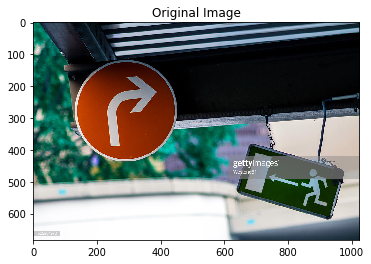

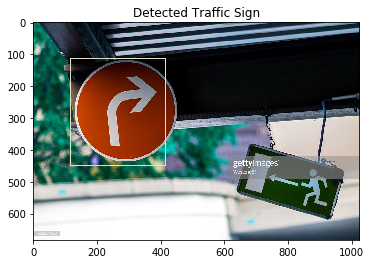

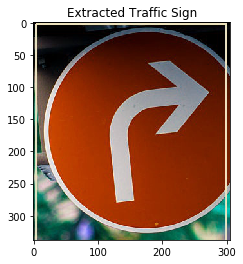

In [30]:
path = os.path.join('..', '..', 'RCNN', 'test_images2', 'raw_img.jpg')
img = cv2.imread(path)

fig = plt.figure()
plt.imshow(img)
plt.title('Original Image')
plt.pause(0.3)

# run frcnn_test.py on above image

path = os.path.join('..', '..', 'RCNN', 'results_imgs', '0.jpg')
img = cv2.imread(path)

fig = plt.figure()
plt.imshow(img)
plt.title('Detected Traffic Sign')
plt.pause(0.3)

path = os.path.join('..', '..', 'RCNN', 'bbox.txt')
f = open(path)
x1, y1, x2, y2 = f.read().split(',')

img = img[int(y1):int(y2), int(x1):int(x2)]

fig = plt.figure()
plt.imshow(img)
plt.title('Extracted Traffic Sign')
plt.pause(0.3)

### 2. Deformation Correction

Loss: 0.002249857410788536
Accuracy: 1.0


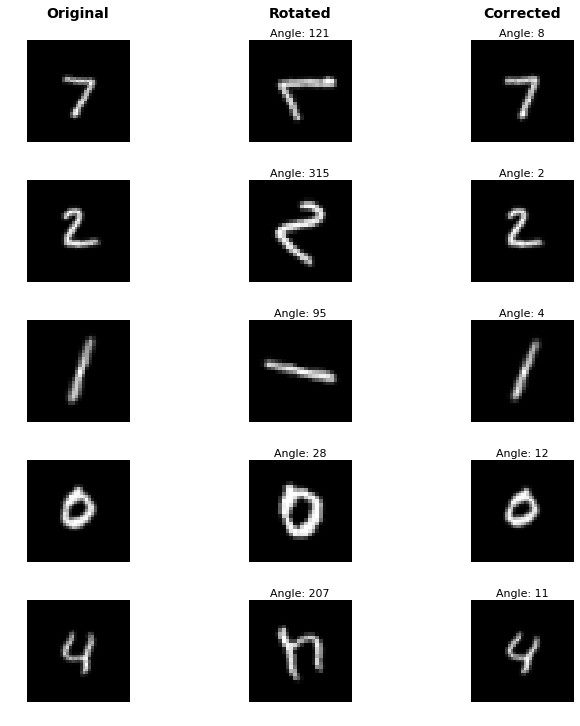

In [26]:
# test_data_path = 'test.p'
# data = np.load(test_data_path, allow_pickle=True)

num_images = 5
# temp = np.zeros((num_images, data['features'].shape[1], data['features'].shape[2]))
# for i in range(num_images):
#     temp[i] = cv2.cvtColor(data['features'][i], cv2.COLOR_BGR2GRAY)

(_, _), (x_test, y_test) = mnist.load_data()
x_test = x_test[:num_images]

y_test = y_test[:num_images]


batch_size = 128

input_dim = 28
classifier_input_dim = 28
num_classes = 10

loc_net_model_name = 'loc_net_mnist_360.hdf5'
loc_net_model_location = os.path.join('..', 'train', 'models', loc_net_model_name)

classifier_model_name = 'classifier_mnist.h5'
classifier_model_location = os.path.join('.', classifier_model_name)

evaluate_deformable_classifier(input_dim, classifier_input_dim, num_classes, loc_net_model_location, 
                               classifier_model_location, 180)